<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BCuritiba%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/curitibadiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,26262.0,26262.000000,13122.000000,13092.000000,13111.000000,12882.000000,12367.000000,13077.000000,13016.000000,13114.000000,0.0
mean,83842.0,600.091387,4.268648,23.547426,13.558195,5.089730,2.285712,17.526644,80.803242,2.183913,NaN
std,0.0,600.011417,10.471597,4.671269,4.052985,3.610441,1.419244,3.875246,9.479680,0.830833,NaN
min,83842.0,0.000000,0.000000,7.100000,-3.500000,0.000000,0.000000,3.300000,0.000000,0.000000,NaN
25%,83842.0,0.000000,0.000000,20.300000,11.000000,1.500000,1.300000,14.900000,75.750000,1.633333,NaN
50%,83842.0,1200.000000,0.000000,23.900000,14.000000,5.400000,2.000000,17.820000,82.000000,2.100000,NaN
75%,83842.0,1200.000000,2.500000,27.200000,16.700000,8.300000,3.000000,20.520000,87.500000,2.633333,NaN
max,83842.0,1200.000000,146.200000,35.200000,22.600000,12.800000,12.500000,27.380000,99.250000,7.366667,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,83842,1980-01-01,0,NaN,24.6,NaN,11.7,7.4,15.94,69.25,3.366667,NaN
1,83842,1980-01-01,1200,0.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2,83842,1980-01-02,0,NaN,25.0,NaN,8.1,1.9,16.52,76.75,1.700000,NaN
3,83842,1980-01-02,1200,0.0,NaN,11.7,NaN,NaN,NaN,NaN,NaN,NaN
4,83842,1980-01-03,0,NaN,27.1,NaN,11.2,2.9,18.92,71.00,1.833333,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,13092.000000,0.0,12882.000000,12367.000000,13077.000000,13016.000000,13114.000000
mean,NaN,23.547426,NaN,5.089730,2.285712,17.526644,80.803242,2.183913
std,NaN,4.671269,NaN,3.610441,1.419244,3.875246,9.479680,0.830833
min,NaN,7.100000,NaN,0.000000,0.000000,3.300000,0.000000,0.000000
25%,NaN,20.300000,NaN,1.500000,1.300000,14.900000,75.750000,1.633333
50%,NaN,23.900000,NaN,5.400000,2.000000,17.820000,82.000000,2.100000
75%,NaN,27.200000,NaN,8.300000,3.000000,20.520000,87.500000,2.633333
max,NaN,35.200000,NaN,12.800000,12.500000,27.380000,99.250000,7.366667


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,13122.000000,0.0,13111.000000,0.0,0.0,0.0,0.0,0.0
mean,4.268648,NaN,13.558195,NaN,NaN,NaN,NaN,NaN
std,10.471597,NaN,4.052985,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,-3.500000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,11.000000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,14.000000,NaN,NaN,NaN,NaN,NaN
75%,2.500000,NaN,16.700000,NaN,NaN,NaN,NaN,NaN
max,146.200000,NaN,22.600000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,24.6,11.7,7.4,15.94,69.25,3.366667
1980-01-02,25.0,8.1,1.9,16.52,76.75,1.700000
1980-01-03,27.1,11.2,2.9,18.92,71.00,1.833333
1980-01-04,27.4,11.2,5.3,18.86,66.25,2.700000
1980-01-05,23.8,12.3,3.2,17.78,73.00,4.500000


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,0.0,9.0
1980-01-02,0.0,11.7
1980-01-03,0.0,14.1
1980-01-04,0.0,12.8
1980-01-05,0.0,13.6


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado 
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,24.6,11.7,7.4,15.94,69.25,3.366667,0.0,9.0
1980-01-02,25.0,8.1,1.9,16.52,76.75,1.700000,0.0,11.7
1980-01-03,27.1,11.2,2.9,18.92,71.00,1.833333,0.0,14.1
1980-01-04,27.4,11.2,5.3,18.86,66.25,2.700000,0.0,12.8
1980-01-05,23.8,12.3,3.2,17.78,73.00,4.500000,0.0,13.6


In [19]:
len(dataSetProv)

13880

In [20]:
dataSetProv.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,13092.000000,12882.000000,12367.000000,13077.000000,13016.000000,13114.000000,13122.000000,13111.000000
mean,23.547426,5.089730,2.285712,17.526644,80.803242,2.183913,4.268648,13.558195
std,4.671269,3.610441,1.419244,3.875246,9.479680,0.830833,10.471597,4.052985
min,7.100000,0.000000,0.000000,3.300000,0.000000,0.000000,0.000000,-3.500000
25%,20.300000,1.500000,1.300000,14.900000,75.750000,1.633333,0.000000,11.000000
50%,23.900000,5.400000,2.000000,17.820000,82.000000,2.100000,0.000000,14.000000
75%,27.200000,8.300000,3.000000,20.520000,87.500000,2.633333,2.500000,16.700000
max,35.200000,12.800000,12.500000,27.380000,99.250000,7.366667,146.200000,22.600000


In [0]:
dataSet = dataSetProv

In [22]:
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,13092.000000,12882.000000,12367.000000,13077.000000,13016.000000,13114.000000,13122.000000,13111.000000
mean,23.547426,5.089730,2.285712,17.526644,80.803242,2.183913,4.268648,13.558195
std,4.671269,3.610441,1.419244,3.875246,9.479680,0.830833,10.471597,4.052985
min,7.100000,0.000000,0.000000,3.300000,0.000000,0.000000,0.000000,-3.500000
25%,20.300000,1.500000,1.300000,14.900000,75.750000,1.633333,0.000000,11.000000
50%,23.900000,5.400000,2.000000,17.820000,82.000000,2.100000,0.000000,14.000000
75%,27.200000,8.300000,3.000000,20.520000,87.500000,2.633333,2.500000,16.700000
max,35.200000,12.800000,12.500000,27.380000,99.250000,7.366667,146.200000,22.600000


In [0]:
#Transformando a coluna Data de volta em uma coluna de informações do dataSet
dataSet = dataSet.reset_index(drop = True)

In [24]:
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
0,24.6,11.7,7.4,15.94,69.25,3.366667,0.0,9.0
1,25.0,8.1,1.9,16.52,76.75,1.700000,0.0,11.7
2,27.1,11.2,2.9,18.92,71.00,1.833333,0.0,14.1
3,27.4,11.2,5.3,18.86,66.25,2.700000,0.0,12.8
4,23.8,12.3,3.2,17.78,73.00,4.500000,0.0,13.6


# Modelagem para previsão de Temperatura Máxima

In [0]:
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [27]:
#Visualizando dados
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
0,11.7,7.4,15.94,69.25,3.366667,0.0,9.0
1,8.1,1.9,16.52,76.75,1.700000,0.0,11.7
2,11.2,2.9,18.92,71.00,1.833333,0.0,14.1
3,11.2,5.3,18.86,66.25,2.700000,0.0,12.8
4,12.3,3.2,17.78,73.00,4.500000,0.0,13.6


In [28]:
tempMax.head()

0    24.6
1    25.0
2    27.1
3    27.4
4    23.8
Name: TempMaxima, dtype: float64

In [0]:
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação robusta, trabalhando com os dados entre os percentis 10 e 90
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [31]:
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,12861.000000,12364.000000,13075.000000,12994.000000,13077.000000,13070.000000,13075.000000
mean,-0.204884,-0.634311,0.181630,0.628305,-0.406976,-0.941574,0.307435
std,0.564343,0.227079,0.321886,0.191075,0.225296,0.143162,0.310806
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.765625,-0.792000,-0.036545,0.526448,-0.556561,-1.000000,0.111111
50%,-0.156250,-0.680000,0.205980,0.652393,-0.429864,-1.000000,0.340996
75%,0.296875,-0.520000,0.430233,0.763224,-0.285068,-0.965800,0.547893
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [33]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(13092, 7)


In [0]:
#Separando conjunto de treino e teste
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
#Adicionando e alterando parâmetros neste dicionário, pode-se aumentar ou diminuir a quantidade de parâmetros a serem testados na modelagem
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [40]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 394.0895 - mean_absolute_error: 19.1469
Epoch 2/200
 - 1s - loss: 182.7713 - mean_absolute_error: 12.6092
Epoch 3/200
 - 1s - loss: 80.8709 - mean_absolute_error: 7.8765
Epoch 4/200
 - 1s - loss: 37.2993 - mean_absolute_error: 5.1409
Epoch 5/200
 - 1s - loss: 24.1485 - mean_absolute_error: 4.0986
Epoch 6/200
 - 1s - loss: 21.9363 - mean_absolute_error: 3.8721
Epoch 7/200
 - 1s - loss: 21.7423 - mean_absolute_error: 3.8368
Epoch 8/200
 - 1s - loss: 13.7416 - mean_absolute_error: 2.9535
Epoch 9/200
 - 1s - loss: 4.2910 - mean_absolute_error: 1.5895
Epoch 10/200
 - 1s - loss: 2.4087 - mean_absolute_error: 1.1915
Epoch 11/200
 - 1s - loss:

In [41]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.304434, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.304434 (0.034363) {'batch_size': 10, 'camadas': 2, 'units': 7}


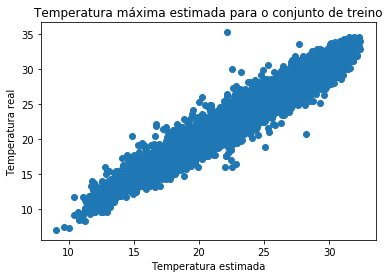

In [42]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [43]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.97025216]
 [0.97025216 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

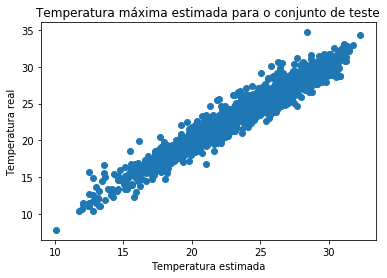

In [45]:
#Gráfico que mostra a relação entre ROP real e ROP previsto
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [46]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.97025408]
 [0.97025408 1.        ]]


In [47]:
#Erro absoluto médio entre o ROP previsto e o real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.9053785584719127


In [48]:
#Erro quadrático médio entre o ROP previsto e o real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

1.3591158827194274


# Modelagem para previsão de Temperatura Mínima

In [0]:
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [51]:
#Visualizando dados
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
0,24.6,11.7,7.4,15.94,69.25,3.366667,0.0
1,25.0,8.1,1.9,16.52,76.75,1.700000,0.0
2,27.1,11.2,2.9,18.92,71.00,1.833333,0.0
3,27.4,11.2,5.3,18.86,66.25,2.700000,0.0
4,23.8,12.3,3.2,17.78,73.00,4.500000,0.0


In [52]:
tempMin.head()

0     9.0
1    11.7
2    14.1
3    12.8
4    13.6
Name: TempMinima, dtype: float64

In [0]:
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação robusta, trabalhando com os dados entre os percentis 10 e 90
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [55]:
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,13075.000000,12881.000000,12366.000000,13076.000000,13015.000000,13098.000000,13100.000000
mean,0.192121,-0.204714,-0.634285,0.181593,0.628262,-0.407335,-0.941507
std,0.338406,0.564150,0.227088,0.321867,0.191026,0.225410,0.143351
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.043478,-0.765625,-0.792000,-0.036545,0.526448,-0.556561,-1.000000
50%,0.217391,-0.156250,-0.680000,0.205980,0.652393,-0.429864,-1.000000
75%,0.456522,0.296875,-0.520000,0.430233,0.763224,-0.285068,-0.964432
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [57]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(13111, 7)


In [0]:
#Separando conjunto de treino e teste
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
#Adicionando e alterando parâmetros neste dicionário, pode-se aumentar ou diminuir a quantidade de parâmetros a serem testados na modelagem
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
#Por limitações de poder de processamento, retirou-se o n_jobs = -1 dos parâmetros do Grid Search
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [67]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 107.5706 - mean_absolute_error: 9.4341
Epoch 2/200
 - 1s - loss: 32.0335 - mean_absolute_error: 4.8077
Epoch 3/200
 - 1s - loss: 17.5502 - mean_absolute_error: 3.4424
Epoch 4/200
 - 1s - loss: 9.8329 - mean_absolute_error: 2.4964
Epoch 5/200
 - 1s - loss: 4.2854 - mean_absolute_error: 1.6440
Epoch 6/200
 - 1s - loss: 2.2329 - mean_absolute_error: 1.1734
Epoch 7/200
 - 1s - loss: 1.7757 - mean_absolute_error: 1.0409
Epoch 8/200
 - 1s - loss: 1.5913 - mean_absolute_error: 0.9806
Epoch 9/200
 - 1s - loss: 1.4904 - mean_absolute_error: 0.9446
Epoch 10/200
 - 1s - loss: 1.4266 - mean_absolute_error: 0.9221
Epoch 11/200
 - 1s - loss: 1.3949 - mean_absolute_error: 0.9094
Epoch 12/200
 - 1s - loss: 1.3584 - mean_absolute_error: 0.8957
Epoch 13/200
 - 1s - loss:

In [68]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.099504, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.099504 (0.100037) {'batch_size': 10, 'camadas': 2, 'units': 7}


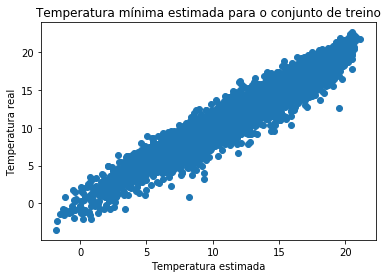

In [69]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [70]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.96723116]
 [0.96723116 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

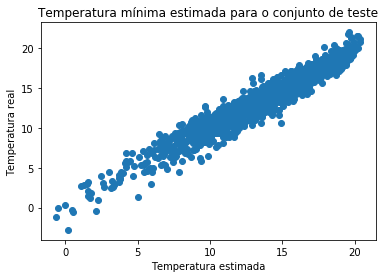

In [72]:
#Gráfico que mostra a relação entre ROP real e ROP previsto
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [73]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.96857274]
 [0.96857274 1.        ]]


In [74]:
#Erro absoluto médio entre o ROP previsto e o real
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.7764718460418829


In [75]:
#Erro quadrático médio entre o ROP previsto e o real
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

1.0211342423667404
